In [1]:
import sys
sys.path.insert(0, '../')

import csaps
import typing
import numpy as np
import numpy
import scipy
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

import pandas as pd

from src.vg2signal import read_raw_vg_as_df, make_detilter, make_smoother

In [2]:
def make_shoulder_getter(vstart: float,
                         vend: float) -> typing.Callable:
    def shoulder_getter_func(v: numpy.array,
                             lisd: numpy.array):
        v_in = numpy.logical_and(v >= vstart, v <= vend)
        spline_model = scipy.interpolate.UnivariateSpline(v[v_in],
                                                          lisd[v_in],
                                                          s=0,
                                                          k=4)

        v_peak = None
        # we are looking for a local minimum of the third derivative between
        # vstart and vend
        spl_mdl_dd = spline_model.derivative(n=2)
        spl_mdl_dd_pred = spl_mdl_dd(v[v_in])

        spl_mdl_ddd = spline_model.derivative(n=3)
        spl_mdl_ddd_pred = spl_mdl_ddd(v[v_in])
        spl_mdl_ddd_b = scipy.interpolate.splrep(v[v_in],
                                                 spl_mdl_ddd_pred)
        spl_mdl_ddd_ppoly = scipy.interpolate.PPoly.from_spline(spl_mdl_ddd_b)
        roots_ddd = spl_mdl_ddd_ppoly.roots(extrapolate=False)
        if len(roots_ddd) == 1:
            v_peak = float(roots_ddd[0])
        elif len(roots_ddd) > 1:
            minsecond = min(spl_mdl_dd_pred)
            idx = (numpy.abs(spl_mdl_dd_pred - minsecond)).argmin()
            vin = list(v[v_in])
            v_peak = vin[idx]
        else:
            minsecond = min(spl_mdl_dd_pred)
            idx = (numpy.abs(spl_mdl_dd_pred - minsecond)).argmin()
            vin = list(v[v_in])
            v_peak = vin[idx]
            print("WARNING: no roots found")
        return (None, v_peak)
    return shoulder_getter_func


In [3]:
def check_signal_validity(vg_filename: str,
             do_log: bool,
             smoothing_bw: float,
             vcenter: float,
             vwidth: float,
             stiffness: float):

    vg_df = read_raw_vg_as_df(vg_filename)

    if (vg_df['I'].to_numpy() < 0).any():
        temp = [None] * 11
        return None

    if do_log:
        cur_var_name = "logI"
        #vg_df[cur_var_name] = np.emath.logn(logbase, vg_df["I"])
        vg_df[cur_var_name] = np.log2(vg_df["I"])
    else:
        cur_var_name = "I"

    smoother = make_smoother(smoothing_bw)

    vg_df["smoothed"] = smoother(vg_df["V"], vg_df[cur_var_name].to_numpy())

    shoulder_getter = make_shoulder_getter(1, 1.1)
    (peak_signal, peak_v_shoulder) = shoulder_getter(vg_df["V"],
                                                     vg_df["smoothed"])

    vcenter = peak_v_shoulder
    vstart = vcenter - 0.5*vwidth
    vend = vcenter + 0.5*vwidth

    detilter = make_detilter(vstart, vend, stiffness)
    vg_df["detilted"] = detilter(vg_df["V"].to_numpy(),
                                 vg_df["smoothed"].to_numpy())
    
    max_signal = vg_df['detilted'].max()  
    min_signal = vg_df['detilted'].min()

    # Invalid data sample when the signal has negative peak higher than positive and has threshold above 0.009
    return (True if (abs(min_signal) > abs(max_signal)) and (abs(min_signal)>0.009) else False), vg_df


def make_detilter(vstart: float,
                  vend: float,
                  stiffness: float) -> typing.Callable:
    assert stiffness >= 0.0, \
        "invalid stiffness parameter (should be " + \
        f"greater than zero): {stiffness}"

    def detilter_func(v: numpy.array, lis: numpy.array):
        v_out  = numpy.logical_or(v < vstart, v > vend)
        lis_bg = csaps.csaps(v[v_out], lis[v_out], v,
                             smooth=(1.0 / (1.0 + stiffness)))
        return (lis - lis_bg), lis_bg

    return detilter_func

In [4]:
# do_log        = True
# recenter      = False
# smoothing_bw  = 0.006
# stiffness     = 1
# vcenter       = 1.04
# vwidth1       = 0.18

# root_path     = '/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset'
# filename_path = [*glob(f'{root_path}/ML1_ML2/2024_02_19_ML1/*.txt'), *glob(f'{root_path}/ML1_ML2/2024_02_22_ML2/*.txt'), *glob(f'{root_path}/ML4/*.txt')]

# list_of_invalid_data = []

# for filename in filename_path:
#     is_invalid, _       = check_signal_validity(filename,
#                             do_log,
#                             smoothing_bw,
#                             vcenter,
#                             vwidth1,
#                             stiffness)
        
#     if is_invalid==None: continue
#     if is_invalid: list_of_invalid_data.append(filename)

In [8]:
!ls

Add_noise_to_signal.ipynb
Analyze_Detilted_signal.ipynb
AutoML.ipynb
Backward_Feature_Selection.ipynb
Check_Model_Transfer_capacity.ipynb
Combine_ML1_ML2_ML4 dataset.ipynb
Feature_Selection_with_hyperparameter_tuning.ipynb
Feature_selection_with_hyperparmeter_tuning.ipynb
Final_Hyperparameter_Tunning.ipynb
Initial_hyperparameter_Tunning.ipynb
K-fold_Ensemble.ipynb
Knowledge_Distillation.ipynb
ML1_ML2_testing.ipynb
Model_Stability_Check.ipynb
Outlier_Detection_whole_dataset.ipynb
Permutation_testing_for_models.ipynb
Raw_Gaussian_Process.ipynb
Remove_ML4.ipynb
SVM_kernel_tuning.ipynb
Test_Batch_Effect.ipynb
Test_Batch_Effect_ComBat.ipynb
Untitled.ipynb
batch_effect
check_batch_effect_in_data.ipynb
conv_neural_network.ipynb
outlier_finding.ipynb
raw_voltammogram.png
raw_voltammogram_.png
raw_voltammogram_dititled.png
raw_voltammogram_zoomed.png
second_derivative.png
second_derivative_with roots.png
third_derivative.png
third_derivative_with_roots.png
train_model_with_noise.ipynb


In [5]:
from src.generate_dataset import v2signal_extra_features
from scipy.signal import savgol_filter, medfilt
from scipy.interpolate import UnivariateSpline

../old_dataset/2023_12_12_LowConc3-alpha/2023_12_12_cbz00_01.txt
Inside Fun 0.005829837358446888
0.005829837358446888


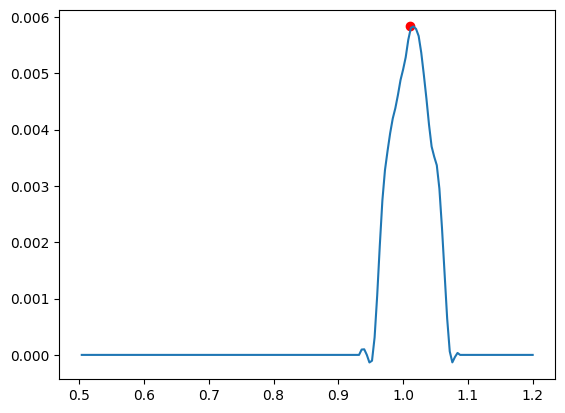

In [9]:
from glob import glob
import os

do_log        = True
recenter      = False
smoothing_bw  = 0.006
stiffness     = 0
vcenter       = 1.04
vwidth1       = 0.15

file     = '2023_12_12_cbz00_01' #'2024_02_22_cbz08_16.txt'
root_path     = os.path.realpath('../dataset')
filename_path = [*glob(f'{root_path}/ML1_ML2/2024_02_19_ML1/*.txt'), 
                 *glob(f'{root_path}/ML1_ML2/2024_02_22_ML2/*.txt'), 
                 *glob(f'{root_path}/ML4/*.txt'),
                 *glob(f'../old_dataset/2023_12_12_LowConc3-alpha/*.txt'),
                 *glob(f'../old_dataset/2023_12_15_LowConc4-beta/*.txt'),
                 *glob(f'../old_dataset/2023_12_17_LowConc5-gamma/*.txt')]


filename = [pathname for pathname in filename_path if (file in pathname)][0]

print(filename)
(peak_signal, peak_curvature, peak_v, vg_df, vcenter, ph, signal_mean, signal_std,\
                dS_dV_max_peak, dS_dV_min_peak, dS_dV_peak_diff, dS_dV_max_V, \
                dS_dV_min_V, dS_dV_area) = v2signal_extra_features(filename,
                                                                    do_log,
                                                                    smoothing_bw,
                                                                    vcenter,
                                                                    vwidth1,
                                                                    stiffness)

# if abs(vg_df['detilted'].min()) > abs(vg_df['detilted'].max()):
#     vg_df['detilted'] = -vg_df['detilted'] # Flip the signal

print(ph)
plt.plot(vg_df['V'], vg_df['detilted'])
plt.scatter(vcenter, ph, c='red')

In [10]:
def calculate_peak_curvature(x, y):
    # Compute first derivatives of x and y
    dx = np.gradient(x)
    dy = np.gradient(y)
    
    # Compute second derivatives of x and y
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    
    # Compute curvature
    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**(3/2)
    
    # Find the index of the peak curvature
    peak_curvature_idx = np.argmax(curvature)
    peak_curvature     = curvature[peak_curvature_idx]

    return peak_curvature, peak_curvature_idx

In [11]:
vstart = 1
vend   = 1.1
v    = vg_df['V']
lisd = vg_df['smoothed']

v_in = numpy.logical_and(v >= vstart, v <= vend)

peak_curvature, peak_curvature_idx = calculate_peak_curvature(v[v_in], lisd[v_in])
v_peak = v[v_in].iloc[[peak_curvature_idx]].to_list()[0]
print(v_peak)

1.072


[1.0108746  1.01807422 1.02403373 1.0325929  1.03475613 1.0441939
 1.05401642 1.07308534 1.08272245 1.09999721]
1.0108745976010576


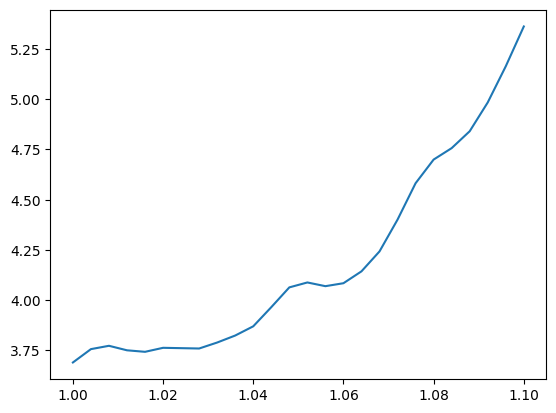

In [12]:
vstart = 1
vend   = 1.1
v    = vg_df['V']
lisd = vg_df['smoothed']

v_in = numpy.logical_and(v >= vstart, v <= vend)

spline_model = scipy.interpolate.UnivariateSpline(v[v_in],
                                                          lisd[v_in],
                                                          s=0,
                                                          k=4)

v_peak = None
# we are looking for a local minimum of the third derivative between
# vstart and vend
spl_mdl_dd      = spline_model.derivative(n=1)
spl_mdl_d_pred  = spl_mdl_dd(v[v_in])

plt.plot(v[v_in], spl_mdl_d_pred)

spl_mdl_dd      = spline_model.derivative(n=2)
spl_mdl_dd_pred = spl_mdl_dd(v[v_in])


# plt.plot(v[v_in], spl_mdl_dd_pred, c='blue')

spl_mdl_ddd      = spline_model.derivative(n=3)
spl_mdl_ddd_pred = spl_mdl_ddd(v[v_in])
spl_mdl_ddd_b    = scipy.interpolate.splrep(v[v_in],
                                          spl_mdl_ddd_pred)



spl_mdl_ddd_ppoly = scipy.interpolate.PPoly.from_spline(spl_mdl_ddd_b)
roots_ddd         = spl_mdl_ddd_ppoly.roots(extrapolate=False)

print(roots_ddd)

if len(roots_ddd) == 1:
    v_peak = float(roots_ddd[0])

elif len(roots_ddd) > 1:
    idx       = spl_mdl_dd(np.array(roots_ddd)).argmin()
    v_peak    = roots_ddd[idx]
    # minsecond = min(spl_mdl_dd_pred)
    # idx = (numpy.abs(spl_mdl_dd_pred - minsecond)).argmin()
    # vin = list(v[v_in])
    # v_peak = vin[idx]

else:
    minsecond = min(spl_mdl_dd_pred)
    idx = (numpy.abs(spl_mdl_dd_pred - minsecond)).argmin()
    vin = list(v[v_in])
    v_peak = vin[idx]
    print("WARNING: no roots found")


print(v_peak)

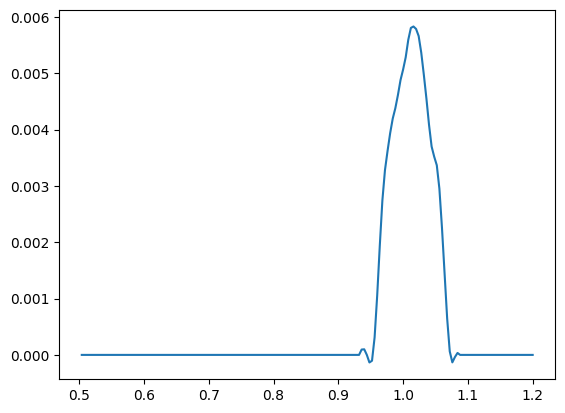

In [13]:
# stiffness       = 0
# shoulder_getter = make_shoulder_getter(1, 1.1)
(peak_signal, peak_v_shoulder) = None, v_peak#shoulder_getter(vg_df["V"],
                                                    # vg_df["smoothed"])

vwidth  = vwidth1

vcenter = peak_v_shoulder
vstart  = vcenter - 0.5*vwidth
vend    = vcenter + 0.5*vwidth

v  = vg_df["V"].to_numpy()
lis= vg_df["smoothed"].to_numpy()

v_out  = numpy.logical_or(v < vstart, v > vend)
lis_bg = csaps.csaps(v[v_out], lis[v_out], v,
                     smooth=(1.0 / (1.0 + stiffness)))

detilter = lis - lis_bg

plt.plot(v, detilter)

0.9358745976010576 1.0858745976010575
1.0108745976010576
1.4927155830767604


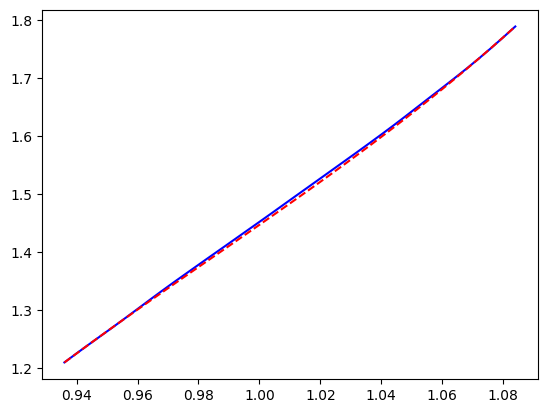

In [14]:

print(vstart, vend)
clip_mask = (vg_df['V'] > vstart) & (vg_df['V'] < vend)

signal_peak = vg_df[vg_df['V']==vcenter]

signal_peak_val = spline_model(vcenter)

print(vcenter)
print(signal_peak_val)


plt.plot(vg_df['V'][clip_mask], vg_df['smoothed'][clip_mask], c='blue')
plt.scatter(signal_peak['V'], signal_peak['smoothed'], c='red')
plt.plot(vg_df['V'][clip_mask], lis_bg[clip_mask], c='red', linestyle='--')

os.makedirs('../results/raw_visualization', exist_ok=True)
plt.savefig('raw_voltammogram_zoomed.png', dpi=300)

In [ ]:
fontsize    = 17
signal_peak = vg_df[vg_df['V']==vcenter]
plt.plot(vg_df['V'], vg_df['detilted'], c='blue')
plt.scatter(signal_peak['V'], signal_peak['detilted'], c='red')
os.makedirs('../results/raw_visualization', exist_ok=True)
plt.xlabel('V', fontsize=fontsize)
plt.ylabel('S', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()
plt.savefig('../results/raw_visualization/raw_voltammogram_detiteled.png', dpi=300)

In [ ]:
clip_mask = (vg_df['V'] >= vstart) & (vg_df['V'] < vend)

signal_peak = vg_df[vg_df['V']==vcenter]

plt.plot(vg_df['V'], vg_df['smoothed'], c='blue')
plt.scatter(vcenter ,signal_peak_val, c='red')
# line,  = plt.plot(vg_df['V'][clip_mask], lis_bg[clip_mask], c='red', linestyle='--')
# line.set_dashes([5, 5, 2, 5])

# plt.axvline(x=vstart, color='r', linestyle='--', label='Vertical Line')
# plt.axvline(x=vend, color='r', linestyle='--', label='Vertical Line')

print(vstart, vend)
plt.scatter(signal_peak['V'], signal_peak['smoothed'], c='red', s=10)
plt.scatter(signal_peak['V'], signal_peak['smoothed'], c='red', s=10)
plt.xlabel('V',fontsize=fontsize)
plt.ylabel('log(I)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# os.makedirs('../results/raw_visualization', exist_ok=True)
plt.tight_layout()
plt.savefig('raw_voltammogram.png', dpi=300)

In [ ]:
vg_df['V'].max()

In [ ]:
plt.plot(vg_df['V'], vg_df['detilted'])

In [ ]:
plt.plot(vg_df['V'], vg_df['detilted'].clip(lower=0.0))

# Analyze finding peak curvature in more detail

In [ ]:
x, y = vg_df['V'], vg_df['smoothed']
v_in = (x >= 1) & (x <= 1.1)

x, y = x[v_in], y[v_in]
spline_model = scipy.interpolate.UnivariateSpline(x,
                                                          y,
                                                          s=0,
                                                          k=4)

plt.plot(x, y)
plt.ylabel('log(I)')
plt.xlabel('V')

In [ ]:
# print(x[y.argmax()])

In [ ]:
spl_mdl_d      = spline_model.derivative(n=1)
spl_mdl_d_pred = spl_mdl_d(x)
plt.plot(x, spl_mdl_d_pred, c='blue')
for i in roots_ddd:
    plt.scatter(i, spl_mdl_d(i))

In [ ]:
spl_mdl_dd      = spline_model.derivative(n=2)
spl_mdl_dd_pred = spl_mdl_dd(x)


plt.plot(x, spl_mdl_dd_pred)
for i in roots_ddd:
    plt.scatter(i, spl_mdl_dd(i))

plt.savefig('second_derivative_with roots', dpi=300)

In [ ]:
x.iloc[spl_mdl_dd_pred.argmin()], spl_mdl_dd_pred.min()

In [ ]:
spl_mdl_ddd      = spline_model.derivative(n=3)
spl_mdl_ddd_pred = spl_mdl_ddd(x)
spl_mdl_ddd_b    = scipy.interpolate.splrep(x,
                                          spl_mdl_ddd_pred)



spl_mdl_ddd_ppoly = scipy.interpolate.PPoly.from_spline(spl_mdl_ddd_b)
roots_ddd         = spl_mdl_ddd_ppoly.roots(extrapolate=False)

print(roots_ddd)

In [ ]:
roots_ddd[spl_mdl_dd(roots_ddd).argmin()]

In [ ]:
plt.plot(x, spl_mdl_ddd_ppoly(x))

for i in roots_ddd:
    plt.scatter(i, spl_mdl_ddd_ppoly(i))

plt.savefig('third_derivative_with_roots', dpi=300)

In [ ]:

plt.plot(x, y)
for i in roots_ddd:
    plt.scatter(i, spline_model(i))